# Imports & Globals

In [1]:
import yaml
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
from StringProcessing import preprocessInput, encode_sequence, pad_sequence, encode_pad_tag, balance_dataset, balance_complete_set, get_target_groups_from_connected_components, generate_synthethic_negative_pairs, generate_noisy_positive_pairs

In [3]:
global MAXLEN # Maximum sequence length including padding
global NOISE  # Maximun noise threshold allowable

In [4]:
with open('LSTM65.yaml', 'r') as file:
    model_config = yaml.safe_load(file)
    MAXLEN = int(model_config['MAXLEN'])
    NOISE = float(model_config['Noise_threshold'])

------------------------------------------------

# Data loading and preprocessing

In [5]:
# fName_unmapped = '../unmapped_data/upper_unmap_orig_drug_names_202201201812.csv'
# unmapped = '../data/upper_unmap_orig-_drug_names_no_model_overlap_20220224.csv'

# Process Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lb        1299 non-null   object
 1   mappings  1299 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['lb', 'mappings'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Balancing target sequence representation:
	Added 11010 new sequences of underrepresented targets.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 335 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13273 entries, 0 to 1

,x,y,Processed_x,Processed_y,Match,Distance
4418,GYBYYRHBZAINFLTATA,ZHANGGUOGANCAO,"[7, 25, 2, 25, 25, 18, 8, 2, 26, 1, 9, 14, 6, ...","[26, 8, 1, 14, 7, 7, 21, 15, 7, 1, 14, 3, 1, 1...",1,0
12607,UGGUL,COMMIPHORA MUKUL,"[21, 7, 7, 21, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 15, 13, 13, 9, 16, 8, 15, 18, 1, 27, 13, 2...",1,0
11654,JGIALS REIGA,JUGLANS REGIA,"[10, 7, 9, 1, 12, 19, 27, 18, 5, 9, 7, 1, 0, 0...","[10, 21, 7, 12, 1, 14, 19, 27, 18, 5, 7, 9, 1,...",1,0


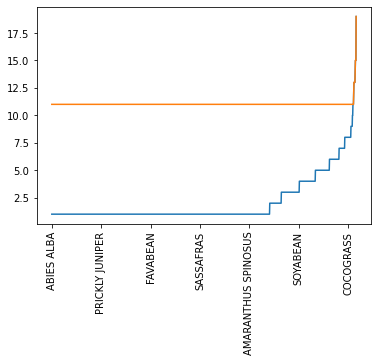

In [6]:
latin_2_common = encode_pad_tag(preprocessInput(filename='../data/vocabulary_LB_to_common_names_09082022.tsv', maxlen= MAXLEN, reflexive=True, balance=True, noise = NOISE, sep='\t'), match=1, distance=0, maxlen=MAXLEN, verbose=True).sort_values(by=['y', 'x', "Distance"])
latin_2_common.sample(n=3)

## Add some Unmapped gsrs positive pairs
Data from 4) positive-unmapped-pairs-gsrs-name-to-common-name.tsv -- POSITIVE unmapped pairs G-SRS to Latin binomial common name

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   common_name     728 non-null    object
 1   latin_binomial  728 non-null    object
dtypes: object(2)
memory usage: 11.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['common_name', 'latin_binomial'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Balancing target sequence representation:
	Added 1340 new sequences of underrepresented targets.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 728 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame

,x,y,Processed_x,Processed_y,Match,Distance
1730,WSAONGA DENSIFEL,WATSONIA DENSIFLORA,"[23, 19, 1, 15, 14, 7, 1, 27, 4, 5, 14, 19, 9,...","[23, 1, 20, 19, 15, 14, 9, 1, 27, 4, 5, 14, 19...",1,0
2012,PHYLNTU S ACMAFUS,PHYLLANTHUS AMARUS,"[16, 8, 25, 12, 14, 20, 21, 27, 19, 27, 1, 3, ...","[16, 8, 25, 12, 12, 1, 14, 20, 8, 21, 19, 27, ...",1,0
764,ONITERVJAPCONICA,LONICERA JAPONICA,"[15, 14, 9, 20, 5, 18, 22, 10, 1, 16, 3, 15, 1...","[12, 15, 14, 9, 3, 5, 18, 1, 27, 10, 1, 16, 15...",1,0


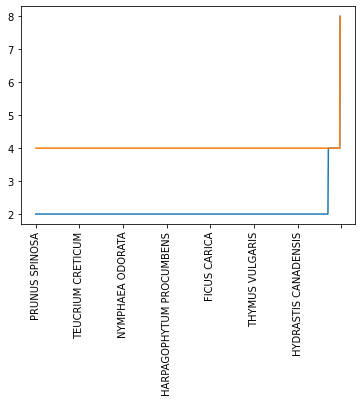

In [7]:
common_2_latin = encode_pad_tag(preprocessInput(filename='../data/positive-unmapped-pairs-common-name-or-latin-binomial-copies.tsv', maxlen= MAXLEN, reflexive=True, balance=True, noise = NOISE, sep='\t'), match=1, distance=0, maxlen=MAXLEN, verbose=True).sort_values(by=['y', 'x', "Distance"])
common_2_latin.sample(n=3)

## Add some positive unmmaped common and latin-binomial pairs
Data from 5) positive-unmapped-pairs-common-name-or-latin-binomial-copies.tsv -- POSITIVE unmapped pairs common-name to common name, common name to Latin binomial and vice versa, Latin binomial to Latin binomial

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         10838 non-null  object
 1   common_name  199 non-null    object
dtypes: object(2)
memory usage: 169.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['name', 'common_name'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 10639 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Balancing target sequence representation:
	Added 3880 new sequences of underrepresented targets.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 205 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex

,x,y,Processed_x,Processed_y,Match,Distance
2661,BLXRC KEPPPE,PIPER NIGRUM WHOLE,"[2, 12, 24, 18, 3, 27, 11, 5, 16, 16, 16, 5, 0...","[16, 9, 16, 5, 18, 27, 14, 9, 7, 18, 21, 13, 2...",1,0
1045,HHORNY GOA WEXEBD,EPIMEDIUM EPIMEDIUM PUBESCENS HOC,"[8, 8, 15, 18, 14, 25, 27, 7, 15, 1, 27, 23, 5...","[5, 16, 9, 13, 5, 4, 9, 21, 13, 27, 5, 16, 9, ...",1,0
2987,BARBERUAY,BERBERIS ARISTATA WHOLE,"[2, 1, 18, 2, 5, 18, 21, 1, 25, 0, 0, 0, 0, 0,...","[2, 5, 18, 2, 5, 18, 9, 19, 27, 1, 18, 9, 19, ...",1,0


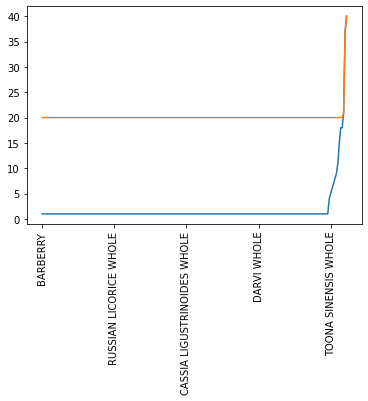

In [8]:
gsrs_2_common = encode_pad_tag(preprocessInput(filename='../data/positive-unmapped-pairs-gsrs-name-to-common-name.tsv', maxlen= MAXLEN, reflexive=True, balance=True, noise = NOISE, sep='\t'), match=1, distance=0, maxlen=MAXLEN, verbose=True).sort_values(by=['y', 'x', "Distance"])
gsrs_2_common.sample(n=3)

## Add Mapped-positive pairs
Data from NP_FAERS_mapped_20220215.csv -- the manually create references set for ~70 drugs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5358 non-null   object
 1   lookup_value      5358 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['FAERS_drug_match', 'lookup_value'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Balancing target sequence representation:
	Added 35474 new sequences of underrepresented targets.
Dropping sequences longer than the maxlen of 65:
	Dropped 847 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 1382 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.cor

,x,y,Processed_x,Processed_y,Match,Distance
27029,EFNUGREC,FENUGREEK,"[5, 6, 14, 21, 7, 18, 5, 3, 0, 0, 0, 0, 0, 0, ...","[6, 5, 14, 21, 7, 18, 5, 5, 11, 0, 0, 0, 0, 0,...",1,0
20156,BURAOCK,NIU BANG ZI,"[2, 21, 18, 1, 15, 3, 11, 0, 0, 0, 0, 0, 0, 0,...","[14, 9, 21, 27, 2, 1, 14, 7, 27, 26, 9, 0, 0, ...",1,0
2046,ELLURA CRANBERRY CAPSULES,CRANBERRY,"[5, 12, 12, 21, 18, 1, 27, 3, 18, 1, 14, 2, 5,...","[3, 18, 1, 14, 2, 5, 18, 18, 25, 0, 0, 0, 0, 0...",1,0


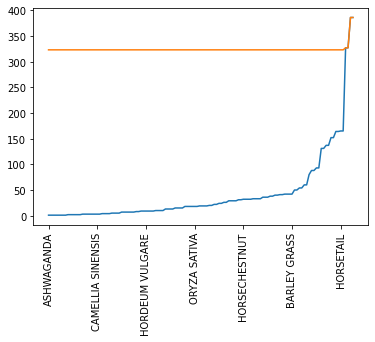

In [9]:
positive_set = encode_pad_tag(preprocessInput('../data/NP_FAERS_mapped_20220215.csv', maxlen= MAXLEN, reflexive=False, balance=True, noise = NOISE, sep=','), match=1, distance=0, maxlen=MAXLEN, verbose=True).sort_values(by=['y', 'x', "Distance"])
positive_set.sample(n=3)

----------------------------------------------

## Add negative pairs from unmmaped
Data from 9) NP_FAERS_negative_pairs_20220222.csv -- the negative pairs created by random sampling from the NP_FAERS_mapped_20220215.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  9242 non-null   object
 1   lookup_value      9242 non-null   object
dtypes: object(2)
memory usage: 144.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['FAERS_drug_match', 'lookup_value'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Balancing target sequence representation:
	Added 98208 new sequences of underrepresented targets.
Dropping sequences longer than the maxlen of 65:
	Dropped 2059 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 5512 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.c

,x,y,Processed_x,Processed_y,Match,Distance
24181,LOXW INDITAH,ALOE VERA,"[12, 15, 24, 23, 27, 9, 14, 4, 9, 20, 1, 8, 0,...","[1, 12, 15, 5, 27, 22, 5, 18, 1, 0, 0, 0, 0, 0...",0,1
23991,LU WNICDICA THC,ALOE VERA,"[12, 21, 27, 23, 14, 9, 3, 4, 9, 3, 1, 27, 20,...","[1, 12, 15, 5, 27, 22, 5, 18, 1, 0, 0, 0, 0, 0...",0,1
43286,EHRBALTEA NPERHPATIN,WOOD SPIDER,"[5, 8, 18, 2, 1, 12, 20, 5, 1, 27, 14, 16, 5, ...","[23, 15, 15, 4, 27, 19, 16, 9, 4, 5, 18, 0, 0,...",0,1


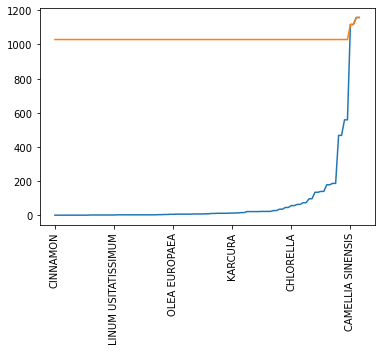

In [10]:
negative_set = encode_pad_tag(preprocessInput(filename = '../data/NP_FAERS_negative_pairs_20220222.csv', maxlen = MAXLEN, reflexive=False, balance=True, noise = NOISE, sep = ","), match=0, distance=1, maxlen=MAXLEN).sort_values(by=['y', 'x', "Distance"])
negative_set.sample(n=3)

## Add negative pairs from unmmaped
Data from 6) negative-unmapped-pairs-all.tsv -- NEGATIVE pairs for the umpapped NP strings from GSRS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11964 entries, 0 to 11963
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   p1      11964 non-null  object
 1   upper   11964 non-null  object
dtypes: object(2)
memory usage: 187.1+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['p1', 'upper'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Balancing target sequence representation:
	Added 42587 new sequences of underrepresented targets.
Dropping sequences longer than the maxlen of 65:
	Dropped 1 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 20 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54530 entries, 0 to 54529
Data

,x,y,Processed_x,Processed_y,Match,Distance
41610,ASTRXADLUSFMEBANAEUS WHOLE,OXYRIA DIGYNA,"[1, 19, 20, 18, 24, 1, 4, 12, 21, 19, 6, 13, 5...","[15, 24, 25, 18, 9, 1, 27, 4, 9, 7, 25, 14, 1,...",0,1
9617,RANUNCULASTRUM NEMORIVAGUM WHOLE,CURCUMA ZEDOARIA,"[18, 1, 14, 21, 14, 3, 21, 12, 1, 19, 20, 18, ...","[3, 21, 18, 3, 21, 13, 1, 27, 26, 5, 4, 15, 1,...",0,1
45458,UNIPERUS KFRGEOTEX WHZ LE,OCIMUM TENUIFLORUM,"[27, 21, 14, 9, 16, 5, 18, 21, 19, 27, 11, 6, ...","[15, 3, 9, 13, 21, 13, 27, 20, 5, 14, 21, 9, 6...",0,1


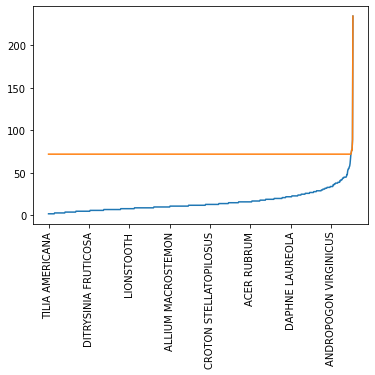

In [11]:
gsrs_2_common_or_latin_negatives = encode_pad_tag(preprocessInput(filename = '../data/negative-unmapped-pairs-all.tsv', maxlen=MAXLEN, reflexive=False, balance=True, noise = NOISE, sep="\t"), match=0, distance=1, maxlen=MAXLEN).sort_values(by=['y', 'x', "Distance"])
gsrs_2_common_or_latin_negatives.sample(n=3)

-----------------------------------

# Merge all dataframes

In [12]:
complete_dataset = pd.concat([positive_set, latin_2_common, common_2_latin, gsrs_2_common, negative_set, gsrs_2_common_or_latin_negatives], ignore_index=True).sort_values(by=['y', 'x', "Distance"])
complete_dataset.drop_duplicates(subset=['x', 'y'], inplace=True)

## Creating Pandas DF for simplified view of all Target Terms

In [13]:
dUnique_df = pd.DataFrame(columns = ['dUnique_label', 'dUnique_seq_padded'])
dUnique_df['dUnique_label'] = complete_dataset['y'].sort_values().unique()
dUnique_df['dUnique_seq_padded'] = dUnique_df['dUnique_label'].transform(encode_sequence).transform(pad_sequence, maxlen=MAXLEN)
dUnique_df.head()

,dUnique_label,dUnique_seq_padded
0,AAI,"[1, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AARONSROD,"[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ..."
2,ABIES ALBA,"[1, 2, 9, 5, 19, 27, 1, 12, 2, 1, 0, 0, 0, 0, ..."
3,ABSINTHE,"[1, 2, 19, 9, 14, 20, 8, 5, 0, 0, 0, 0, 0, 0, ..."
4,ABSINTHE WORMWOOD,"[1, 2, 19, 9, 14, 20, 8, 5, 27, 23, 15, 18, 13..."


Encoding and Padding: ----------------------------------
	Processing x
	Processing y
Tagging: -----------------------------------------------


,x,y,Processed_x,Processed_y,Match,Distance
183,BERBERIS SIKKIMENSIS WHOLE,BERBERIS SIKKIMENSIS WHOLE,"[2, 5, 18, 2, 5, 18, 9, 19, 27, 19, 9, 11, 11,...","[2, 5, 18, 2, 5, 18, 9, 19, 27, 19, 9, 11, 11,...",1,0
1021,LENTISCUS,LENTISCUS,"[12, 5, 14, 20, 9, 19, 3, 21, 19, 0, 0, 0, 0, ...","[12, 5, 14, 20, 9, 19, 3, 21, 19, 0, 0, 0, 0, ...",1,0
1545,SESBANIA SESBAN,SESBANIA SESBAN,"[19, 5, 19, 2, 1, 14, 9, 1, 27, 19, 5, 19, 2, ...","[19, 5, 19, 2, 1, 14, 9, 1, 27, 19, 5, 19, 2, ...",1,0


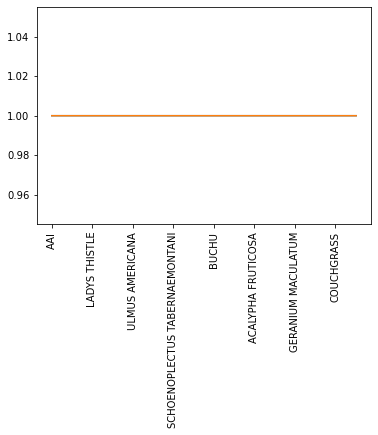

In [14]:
tartget2target = encode_pad_tag(balance_dataset(pd.DataFrame.from_dict({"x": dUnique_df['dUnique_label'].to_list(), "y": dUnique_df['dUnique_label'].to_list()}), noise_percent = NOISE, maxlen = MAXLEN), match=1, distance=0, maxlen=MAXLEN)
tartget2target.sample(3)

In [15]:
tartget2target.head()

,x,y,Processed_x,Processed_y,Match,Distance
0,AAI,AAI,"[1, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
1,AARONSROD,AARONSROD,"[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ...","[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ...",1,0
2,ABIES ALBA,ABIES ALBA,"[1, 2, 9, 5, 19, 27, 1, 12, 2, 1, 0, 0, 0, 0, ...","[1, 2, 9, 5, 19, 27, 1, 12, 2, 1, 0, 0, 0, 0, ...",1,0
3,ABSINTHE,ABSINTHE,"[1, 2, 19, 9, 14, 20, 8, 5, 0, 0, 0, 0, 0, 0, ...","[1, 2, 19, 9, 14, 20, 8, 5, 0, 0, 0, 0, 0, 0, ...",1,0
4,ABSINTHE WORMWOOD,ABSINTHE WORMWOOD,"[1, 2, 19, 9, 14, 20, 8, 5, 27, 23, 15, 18, 13...","[1, 2, 19, 9, 14, 20, 8, 5, 27, 23, 15, 18, 13...",1,0


In [16]:
complete_dataset = pd.concat([complete_dataset, tartget2target], ignore_index=True)
complete_dataset.drop_duplicates(subset=['x', 'y'], inplace=True)
for column in ['x', 'y']:
        complete_dataset.drop(complete_dataset[complete_dataset[column].apply(len).gt(MAXLEN)].index, inplace = True)

In [17]:
noisy_positives = generate_noisy_positive_pairs(tartget2target, scale = 10.0, noise_percent = NOISE, maxlen = MAXLEN)
noisy_positives.sample(n=3)

Encoding and Padding: ----------------------------------
	Processing x
	Processing y
Tagging: -----------------------------------------------


,x,y,Processed_x,Processed_y,Match,Distance
10350,JPYANSESE ANGELICAOREE,JAPANESE ANGELICATREE,"[10, 16, 25, 1, 14, 19, 5, 19, 5, 27, 1, 14, 7...","[10, 1, 16, 1, 14, 5, 19, 5, 27, 1, 14, 7, 5, ...",1,0
18352,RBUUS PARFVFSU,RUBUS PARVIFOLIUS,"[18, 2, 21, 21, 19, 27, 16, 1, 18, 6, 22, 6, 1...","[18, 21, 2, 21, 19, 27, 16, 1, 18, 22, 9, 6, 1...",1,0
17462,DDHNE LAUAREWLA,DAPHNE LAUREOLA,"[4, 4, 8, 14, 5, 27, 12, 1, 21, 1, 18, 5, 23, ...","[4, 1, 16, 8, 14, 5, 27, 12, 1, 21, 18, 5, 15,...",1,0


In [18]:
complete_dataset = pd.concat([complete_dataset, noisy_positives], ignore_index=True).sort_values(by=['y', 'x', "Distance"])
complete_dataset.drop_duplicates(subset=['x', 'y'], inplace=True)
for column in ['x', 'y']:
        complete_dataset.drop(complete_dataset[complete_dataset[column].apply(len).gt(MAXLEN)].index, inplace = True)

# Join All positive sets into one

In [19]:
all_positives = pd.concat([positive_set, latin_2_common, common_2_latin, gsrs_2_common, tartget2target], ignore_index=True).sort_values(by=['y', 'x', "Distance"])

# Extract the equivalence groups

In [20]:
equivalence_groups = get_target_groups_from_connected_components(all_positives)

In [21]:
# equivalence_groups
# {len(group) for group in equivalence_groups}

In [ ]:
complete_dataset = balance_complete_set(complete_dataset, target_groups = equivalence_groups, noise_percent = NOISE, maxlen = MAXLEN)

## Generate additional sythenthic negative pairs

## Add additional negative pairs 
Generated from the positive data using generate_synthethic_negative_pairs

In [ ]:
# synth_negatives = generate_synthethic_negative_pairs(all_positives, equivalences = equivalence_groups, noise = NOISE, scale = 2.0, maxlen = MAXLEN)
# synth_negatives.sample(n=3)

In [ ]:
# complete_dataset = pd.concat([complete_dataset, synth_negatives], ignore_index=True)
# complete_dataset.drop_duplicates(subset=['x', 'y'], inplace=True)

## Generate additional noisy positive pairs

In [ ]:
# noisy_positives = generate_noisy_positive_pairs(all_positives, scale = 2.0, noise_percent = NOISE, maxlen = MAXLEN)
# noisy_positives.sample(n=3)

In [ ]:
# complete_dataset = pd.concat([complete_dataset, noisy_positives], ignore_index=True).sort_values(by=['y', 'x', "Distance"])
# complete_dataset.drop_duplicates(subset=['x', 'y'], inplace=True)

In [ ]:
for column in ['x', 'y']:
        complete_dataset.drop(complete_dataset[complete_dataset[column].apply(len).gt(MAXLEN)].index, inplace = True)

## Create the train/test split

In [ ]:
train, test = train_test_split(complete_dataset.sort_values(by=['y', 'x', "Distance"]), test_size=2500, shuffle=True, random_state=787)

In [ ]:
print("Train:", train.shape, "Test:" , test.shape)

In [ ]:
train['Distance'].value_counts(ascending=True)

In [ ]:
test['Distance'].value_counts(ascending=True)

In [ ]:
x1TrainRnnS, x1ValRnnS, x2TrainRnnS, x2ValRnnS, yTrainRnnS, yValRnnS = train_test_split(train['Processed_x'], train['Processed_y'], train['Distance'], test_size=0.40, random_state=787)

In [ ]:
print("Train Tower 1 x:", len(x1TrainRnnS), ", Test Tower 1 x:", len(x1ValRnnS))
print("Train Tower 2 x:", len(x2TrainRnnS), ", Test Tower 2 x:", len(x2ValRnnS))
print("Train Target  y:", len(yTrainRnnS),  ", Test Target  y:", len(yValRnnS))

In [ ]:
dUnique_df.index.size

In [ ]:
complete_dataset["Distance"].value_counts(ascending=True)

In [ ]:
complete_dataset["y"].value_counts(ascending=True).plot(rot=90)

# Save data to csv

In [ ]:
save = input("Want to save this dataset? (y/n): ")

if save.lower() == "y": 
    pd.DataFrame(data={"x1": x1TrainRnnS, "x2": x2TrainRnnS, "y": yTrainRnnS}).to_pickle("../data/proccesed_train_set.pkl")
    pd.DataFrame(data={"x1": x1ValRnnS, "x2": x2ValRnnS, "y": yValRnnS}).to_pickle("../data/proccesed_test_set.pkl")
    dUnique_df.to_pickle("../data/dUnique_df.pkl")
    negative_set.to_pickle("../data/dfneg2.pkl")
    train.to_pickle("../data/train.pkl")
    test.to_pickle("../data/test.pkl")
    print("Done saving!")



-------